In [102]:
import pandas as pd

!pip3 install catboost
from IPython.display import clear_output

clear_output()

In [103]:
# population get

Population_file_path = 'Distance.xlsx'
population = pd.read_excel(Population_file_path, sheet_name='Population_quart')
population = list(population.Population)

number_of_quarts = len(population)

In [104]:
# distance get

Distance_file_path = 'Distance.xlsx'
distance = pd.read_excel(Distance_file_path, sheet_name='Distance_from_quart', index_col='Id')

distance_from_market = {}
ids = []
for Id in distance.columns:
    distance_from_market[Id] = list(distance[Id])
    ids.append(Id)

In [105]:
# market data get

Markets_file_path = 'Market_data_changed21.xlsx' # 21 is best for MAE - 25000epochs, 41 for MAPE - 8000epochs
market_data = pd.read_excel(Markets_file_path, index_col='Full_Address')

Coord_file_path = 'Coord.xlsx'
coord = pd.read_excel(Coord_file_path, index_col='Full_Address')

market_data = market_data.join(coord)

market_data = market_data.reset_index()
market_data.head()

,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [106]:
# square get

square_of_market = []
for row in market_data.iterrows():
    square_of_market.append({'Id': row[1]['Id'], 'Square': row[1]['Square']})

number_of_markets = len(square_of_market)

In [107]:
# Huff gravity model

# i - number of quart, j- number of market
def huff_probability(i, j, lmbd=0.1):
    Id = square_of_market[j]['Id']
    s_t = square_of_market[j]['Square'] / distance_from_market[Id][i] ** lmbd

    sum_s_t = 0

    for market in square_of_market:
        sum_s_t += market['Square'] / distance_from_market[market['Id']][i] ** lmbd

    return s_t / sum_s_t


huff_pred_by_market = []

for j in range(number_of_markets):
    byuers_count = 0
    for i in range(number_of_quarts):
        prob = huff_probability(i, j)
        byuers_count += prob * population[i]
    huff_pred_by_market.append(byuers_count)

In [108]:
# Huff insertion in DataFrame

market_data.insert(0, 'Huff', huff_pred_by_market)
market_data.head()

,Huff,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,982.338994,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,999.594917,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,2282.540896,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,1904.088952,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,1885.942383,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [109]:
# Features and Target

X = market_data
y = market_data['Frequency']
X = X.drop(['Frequency'], axis=1)

X = X.drop(['Full_Address'], axis=1)
#X = X.drop(['Square'], axis=1)
#X = X.drop(['Huff'], axis=1)
X = X.drop(['Traffic'], axis=1)
X = X.drop(['Time'], axis=1)
X = X.drop(['Id'], axis=1)
X = X.drop(['lat'], axis=1)
X = X.drop(['lon'], axis=1)
#X = X.drop(['Type'], axis=1)
#X = X.drop(['Categorical_Brand'], axis=1)
#X = X.drop(['Building_Type'], axis=1)


categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

X.head()

,Huff,Type,Square,Categorical_Brand,Building_Type
0,982.338994,магазин,126.0,Другие,жилой дом
1,999.594917,магазин,131.0,Другие,жилой дом
2,2282.540896,супермаркет,295.0,Пятерочка,жилой дом
3,1904.088952,супермаркет,253.7,Пятерочка,жилой дом
4,1885.942383,супермаркет,251.0,ВкусВилл,жилой дом


In [110]:
# One-hot encoding

X = pd.get_dummies(X, columns=categorical_cols)

In [111]:
# Model

import torch
from torch import nn
from torch.nn import MSELoss, L1Loss
from torchmetrics import MeanAbsolutePercentageError

torch.manual_seed(17)

class NeuralNetwork(torch.nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(X.columns), 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred


loss = L1Loss()
loss1 = MSELoss()
loss2 = MeanAbsolutePercentageError()

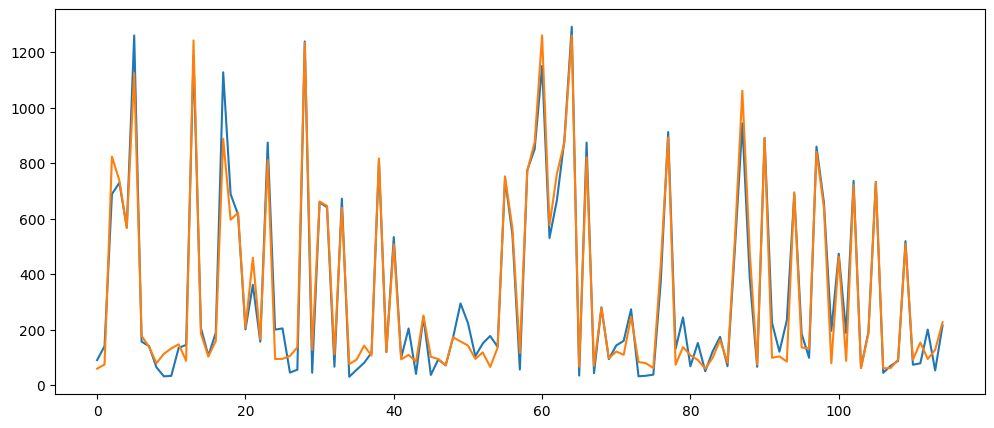

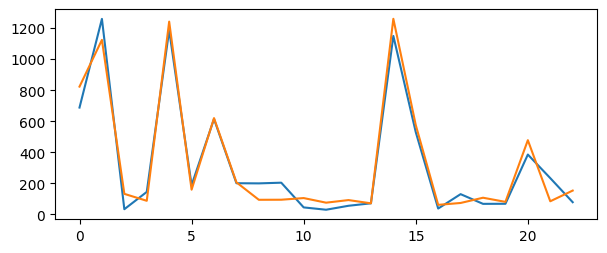

64.6240463256836
all data: 43.40760040283203


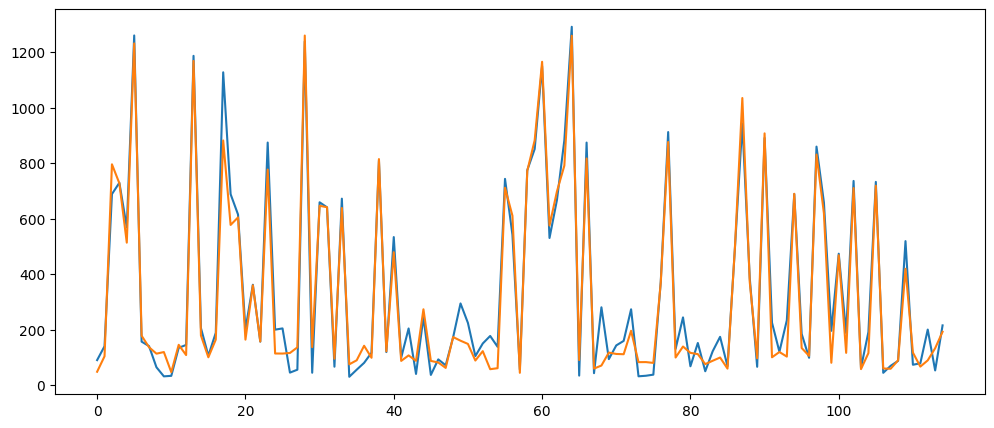

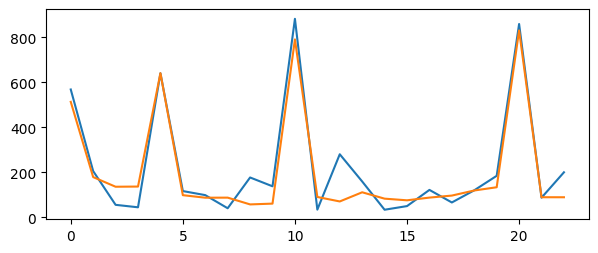

55.10107421875
all data: 45.1882209777832


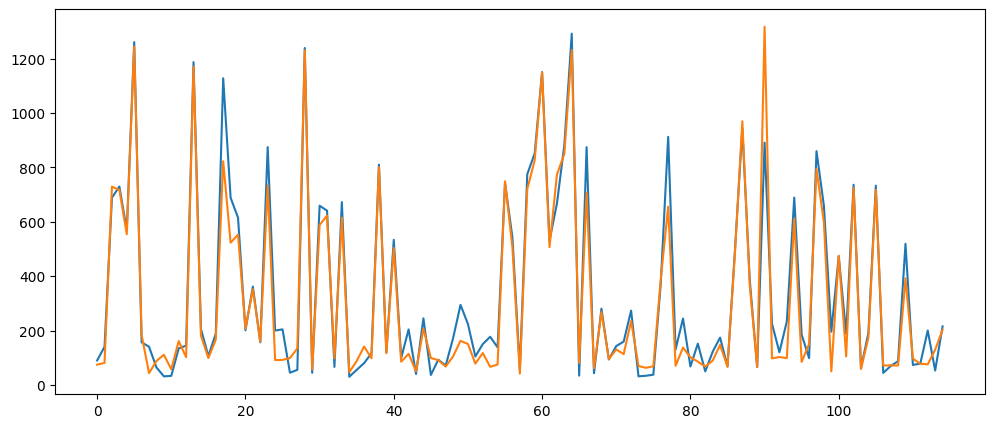

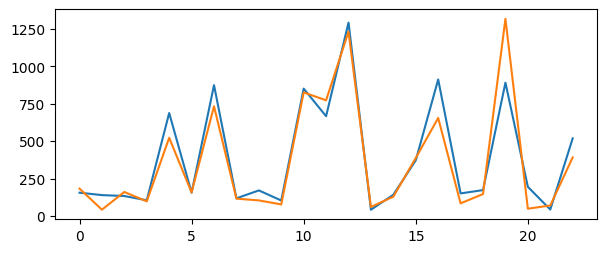

81.57776641845703
all data: 51.425315856933594


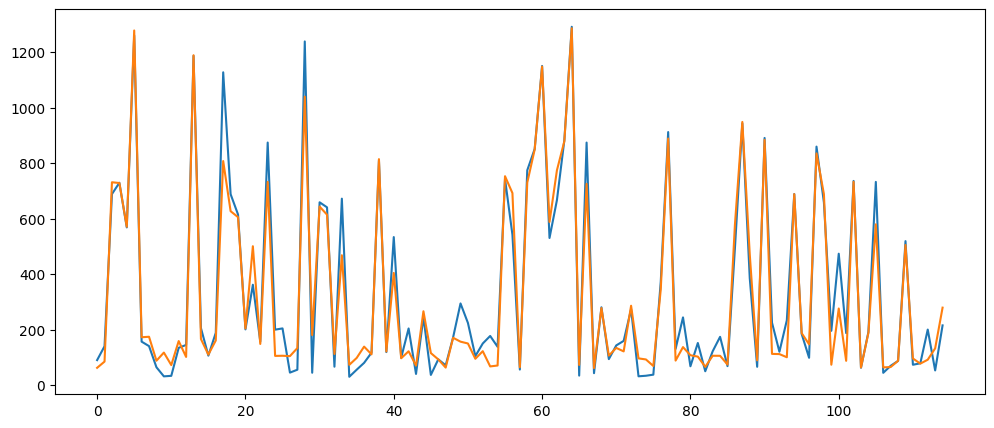

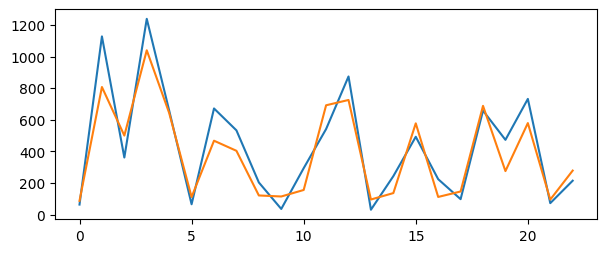

111.23999786376953
all data: 49.93810272216797


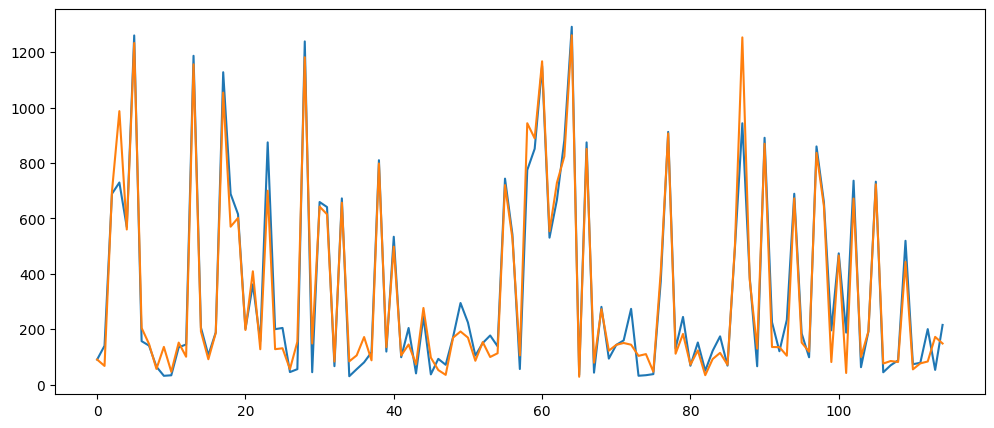

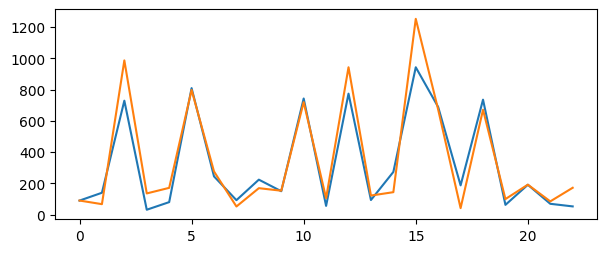

77.2737045288086
all data: 45.19198226928711
valid data mean: 77.96331787109375
all data mean: 47.03024444580078


In [112]:
# train test and cross-validation

from sklearn.model_selection import KFold
from torch.autograd import Variable


kf = KFold(n_splits=5, random_state=4, shuffle=True)

metrics_valid = []
metrics_all = []

x_data_all = Variable(torch.Tensor(X.values))
y_data_all = Variable(torch.Tensor([[target] for target in y.values]))

for train_ind, test_ind in kf.split(X):

    x_data_train = Variable(torch.Tensor(X.values[train_ind]))
    y_data_train = Variable(torch.Tensor([[target] for target in y.values[train_ind]]))

    x_data_valid = Variable(torch.Tensor(X.values[test_ind]))
    y_data_valid = Variable(torch.Tensor([[target] for target in y.values[test_ind]]))

    m_model = NeuralNetwork()

    optimizer_ln = torch.optim.Adam(m_model.parameters(), lr=0.008)

    for epoch in range(20001):
        pred_y = m_model(x_data_train)
        loss_ln = loss(pred_y, y_data_train)

        optimizer_ln.zero_grad()
        loss_ln.backward()
        optimizer_ln.step()


    m_predictions = m_model(x_data_valid)
    m_predictions_all = m_model(x_data_all)

    import matplotlib.pyplot as plt
    fig1 = plt.figure(figsize=(12, 5))
    fig2 = plt.figure(figsize=(7, 6))
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(211)

    ax1.plot(list(i for i in range(len(y))), list(y))
    ax1.plot(list(i for i in range(len(y))), m_predictions_all.tolist())
    ax2.plot(list(i for i in range(len(y_data_valid.tolist()))), list(y_data_valid.tolist()))
    ax2.plot(list(i for i in range(len(y_data_valid.tolist()))), m_predictions.tolist())
    plt.show()

    loss_valid = loss(m_predictions, y_data_valid)
    loss_all = loss(m_predictions_all, y_data_all)
    metrics_valid.append(loss_valid.item())
    metrics_all.append(loss_all.item())

    print(loss_valid.item())
    print('all data:', loss_all.item())

from statistics import mean

print('valid data mean:', mean(metrics_valid))
print('all data mean:', mean(metrics_all))